# Training a LSTM / QLSTM classifier

Long Short-Term Memory (LSTM) networks have been a major breaktrough in natural language processing in learning sequential data and dependencies such as seen in text data. Although, their performance has been surpassed by the Transformer architecture, it is still interesting to see how LSTM can be improved by introducing quantum computing. In the quantum age a quantum-enhanced LSTM (QLSTM) might bring several advantages compared to its classical counterpart.

In this notebook we present a full step working implementation of a hybrid-quantum-classical QLSTM neural network implemented in PyTorch. Starting with loading and transforming the datasets used in the proposed paper, the notebooks shows every step on how to train a LSTM / QLSTM and evaluate the trained model.

For more details on the inner workings of a QLSTM refer to "Quantum Long Short-Term Memory” by Chen, Yoo and Fang (arXiv:2009.01783)". The original implementation of a QLSTM cell was proposed by “The Dawn of Quantum Natural
Language Processing" by Di Sipio, Huang and Chen, et al. (arXiv:2110.06510), which we slighlty modified for our experiments.

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from qlstm_cell import QLSTMCell
import numpy as np
import time

Set torch device

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load dataset

Labels:
- 0 : negative
- 1 : neutral
- 2 : positive

In [18]:
# Any text dataset in the same format can be used here
df = pd.read_csv("data/low_complexity.csv")
df = df.dropna()

# convert class name
X = df["text"].to_list()
y = df["label"].to_list()

df.head()

,text,label
0,Tesla stock surges again,2
1,Inflation fears rattle markets,0
2,Apple reports record profits,2
3,Interest rates stay steady,1
4,Amazon shares drop sharply,0


Create vocabulary of dataset

In [19]:
tokens = [x_i.split(" ") for x_i in X]

word_to_ix = {0: 0}  # padding idx
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent in tokens:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
vocab_size = len(word_to_ix.keys())
print(f"Vocab size: {vocab_size}")

Vocab size: 913


Split dataset into train, val and test segments

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

print(f"Train: {len(y_train)}; Val: {len(y_val)}; Test: {len(y_test)}")

Train: 756; Val: 85; Test: 211


Dataset and Dataloader wrapper for batched training

In [21]:
class SentimentDataset(Dataset):
    def __init__(self, X, y, to_ix: dict, device):
        self.X = X
        self.y = y
        self.to_ix = to_ix

        # transform text to ix in vocab
        self.X_ix = [self._transform_to_ix(x_i.split(" ")) for x_i in X]
        # pad sequences to same length
        pad_len = len(max(self.X_ix, key=len))
        self.X_pad = self._pad_seq(self.X_ix, pad_len)
        # to tensor
        self.X_t = torch.LongTensor(self.X_pad).to(device)

        # transform labels to tensors
        self.y_t = torch.LongTensor(y).to(device)

    def _transform_to_ix(self, seq):
        idxs = [self.to_ix[w] for w in seq]
        return idxs

    def _pad_seq(self, X, length: int):
        padded = []
        for row in X:
            p = np.pad(row, (0, length - len(row))).tolist()
            padded.append(p)
        return np.asarray(padded, dtype=np.int32)

    def __len__(self):
        return len(self.y_t)

    def __getitem__(self, idx):
        return self.X_t[idx], self.y_t[idx]

In [22]:
batch_size = 64

dataset_train = SentimentDataset(X_train, y_train, word_to_ix, device)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = SentimentDataset(X_val, y_val, word_to_ix, device)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataset_test = SentimentDataset(X_test, y_test, word_to_ix, device)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Define pytorch module for qlstm / lstm classifier

In [23]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        embedding_dim: int = 8,
        hidden_dim: int = 32,
        vocab_size: int = 100,
        output_size: int = 2,
        n_qubits: int = 4,
        n_qlayers: int = 1,
        qml_device: str = "default.qubit",
        learning_rate: float = 0.1,
        n_epochs: int = 300,
        batch_size: int = 1,
        linear_dropout: float = 0.1,
        rnn_dropout: float = 0.1,
        rnn_layers: int = 1,
        weight_decay: float = 1e-5,
        momentum: float = 0.9,
        rnn: str = "lstm",
        rnn_bidirectional: bool = False,
        torch_device=torch.device("cpu"),
    ):
        super(LSTMClassifier, self).__init__()
        # params
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.batch_size = batch_size
        self.rnn_dropout = rnn_dropout
        self.linear_dropout = linear_dropout
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.rnn_layers = rnn_layers
        self.rnn_bidirectional = rnn_bidirectional
        self.qml_device = qml_device
        self.torch_device = torch_device

        # init word embeddings
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if rnn == "qlstm":
            print("Model will use Quantum LSTM")
            self.lstm = QLSTMCell(
                self.embedding_dim,
                hidden_dim,
                n_qubits=self.n_qubits,
                n_qlayers=self.n_qlayers,
                qml_device=self.qml_device,
                torch_device=self.torch_device,
            )
        elif rnn == "lstm":
            print("Model will use Classical LSTM")
            self.lstm = nn.LSTM(
                self.embedding_dim,
                hidden_dim,
                batch_first=True,
                num_layers=rnn_layers,
                dropout=self.rnn_dropout,
                bidirectional=rnn_bidirectional,
            )
        elif rnn == "gru":
            print("Model will use Classical GRU")
            self.lstm = nn.GRU(
                self.embedding_dim,
                hidden_dim,
                batch_first=True,
                num_layers=rnn_layers,
                dropout=self.rnn_dropout,
                bidirectional=rnn_bidirectional,
            )
        else:
            raise ValueError("Invalid rnn layer")

        self.D = 2 if rnn_bidirectional else 1  # lstm bidirectional hidden states
        self.hidden_layers = nn.Sequential(
            nn.Linear(self.D * hidden_dim, self.D * hidden_dim), nn.ReLU()
        )

        # The linear layer that maps from hidden state space to tag space
        self.label = nn.Linear(self.D * hidden_dim, output_size)

        self.optimizer = optim.RMSprop(
            self.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            momentum=momentum,
        )
        self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, "min")

        self.loss_function = nn.NLLLoss()
        self.dropout = nn.Dropout(p=self.linear_dropout)

    def forward(self, sentence):
        # transform from word indices to word embeddings
        embeds = self.word_embeddings(sentence)

        # pass through lstm layers
        lstm_out, _ = self.lstm(embeds)
        out = lstm_out[:, -1, :]  # last hidden state of lstm output

        # hidden layers
        out = self.hidden_layers(out)

        # apply dropout
        out = self.dropout(out)

        # cast to number of classes
        logits = self.label(out)

        # cast to log softmax probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        self.history = {
            "train/loss": [],
            "train/acc": [],
            "val/loss": [],
            "val/acc": [],
        }

        # iterate epochs
        for epoch in range(self.n_epochs):
            self.train()  # set train mode
            losses = []
            preds = []
            targets = []

            # iterate batches
            for i, (sentence, label) in enumerate(train_loader):
                # Step 1. Remember that Pytorch accumulates gradients.
                # We need to clear them out before each instance
                self.optimizer.zero_grad()

                # Step 2. Run our forward pass.
                y_hat = self(sentence)

                # Step 3. Compute the loss, gradients, and update the parameters by
                #  calling optimizer.step()
                loss = self.loss_function(y_hat, label)
                loss.backward()
                self.optimizer.step()
                losses.append(float(loss))
                preds.append(y_hat.argmax(dim=-1))
                targets.append(label)

            avg_loss = np.mean(losses)
            self.history["train/loss"].append(avg_loss)

            preds = torch.cat(preds)
            targets = torch.cat(targets)
            corrects = preds == targets
            accuracy = corrects.sum().float() / float(targets.size(0))
            self.history["train/acc"].append(accuracy)

            # calc validation loss and accuracy
            val_loss, val_acc = self._validate(val_loader)

            print(
                f"Epoch {epoch+1} / {self.n_epochs}: train/Loss = {avg_loss:.3f} val/Loss = {val_loss:.3f} train/Acc = {accuracy:.2f} val/Acc = {val_acc:.2f}"
            )

    def _validate(self, val_loader: DataLoader):
        self.eval()  # set eval mode
        y_hat = []
        y_pred = []
        y_true = []

        # iterate batches and predict on val set
        for X_val, y_val in val_loader:
            probs = self(X_val)
            y_hat.append(probs)
            y_pred.append(probs.argmax(dim=-1))
            y_true.append(y_val)

        y_hat = torch.cat(y_hat)
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
        corrects = y_pred == y_true
        val_acc = corrects.sum().float() / float(y_true.size(0))
        val_loss = float(self.loss_function(y_hat, y_true))

        self.history["val/loss"].append(val_loss)
        self.history["val/acc"].append(val_acc)

        return val_loss, val_acc

    def predict(self, test_loader):
        self.eval()
        y_pred = []
        for X, _ in test_loader:
            y_hat = self(X)
            preds = torch.argmax(y_hat, axis=1).cpu().numpy().tolist()
            y_pred.extend(preds)
        return y_pred

## Training a LSTM and QLSTM

Now we will train both a classical LSTM and a quantum-hybrid QLSTM and compare them with each other.

First, let's define a way to plot the training curve behavior of a model to compare the results.

In [29]:
from matplotlib.ticker import MaxNLocator


def plot_training(history, show=True):
    fig, ax1 = plt.subplots()

    # move tensors to cpu device
    history["train/acc"] = [t.cpu() for t in history["train/acc"]]
    history["val/acc"] = [t.cpu() for t in history["val/acc"]]

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    x_range = range(1, len(history["train/loss"]) + 1)  # correct x ticks
    line1 = ax1.plot(x_range, history["train/loss"], color="orange", label="Train loss")
    line2 = ax1.plot(
        x_range, history["val/loss"], color="red", linestyle="dashed", label="Val loss"
    )

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    line3 = ax2.plot(
        x_range, history["train/acc"], color="steelblue", label="Train accuracy"
    )
    line4 = ax2.plot(
        x_range,
        history["val/acc"],
        color="blue",
        linestyle="dashed",
        label="Val accuracy",
    )

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.tight_layout()
    # Shrink current axis by 20%
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    lines = line1 + line2 + line3 + line4
    legend_labels = [l.get_label() for l in lines]
    ax1.legend(lines, legend_labels, loc="upper left", bbox_to_anchor=(1.3, 0.7))

    fig.savefig(f"{rnn}_{n_qlayers}_{n_qubits}.pdf")
    if show:
        fig.show()

Additionally, we define a function to evaluate the trained model on the test data set.

In [30]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import label_binarize


def eval_metrics(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    # binarize labels for multi class auc score
    labels = list(set(y_test))
    y_test_bin = label_binarize(y_test, classes=labels)
    y_pred_bin = label_binarize(y_pred, classes=labels)
    auc = roc_auc_score(y_test_bin, y_pred_bin, average="weighted", multi_class="ovo")

    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, f1, auc, mcc

## Training classical case: LSTM

Define hyperparameters and start training for classical LSTM

In [33]:
embedding_dim = 10
hidden_dim = 16
output_size = len(np.unique(y))
n_epochs = 20
n_qubits = 4
n_qlayers = 1
learning_rate = 1e-2
linear_dropout = 0 # dropout for linear layers
rnn_dropout = 0 # dropout for classical rnn layers
rnn_layers = 1 # number of classical rnn layers
weight_decay = 1e-4 # weight decay for optimizer / l2 regularization
momentum = 0 # momentum for optimizer
rnn = "lstm" # rnn layer -> lstm/qlstm/gru
rnn_bidirectional = False # bidirectionality for classical rnn layer

model = LSTMClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    output_size=output_size,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    linear_dropout=linear_dropout,
    rnn_dropout=rnn_dropout,
    rnn_layers=rnn_layers,
    batch_size=batch_size,
    weight_decay=weight_decay,
    momentum=momentum,
    rnn=rnn,
    rnn_bidirectional=rnn_bidirectional,
    n_qubits=n_qubits,
    n_qlayers=n_qlayers,
    torch_device=device,
)
model.to(device)

# start training and track time
start_time = time.time()

model.fit(train_loader, val_loader)

training_time = round(time.time() - start_time, 2)
print(f"Training time: {training_time}sec")

Model will use Classical LSTM
Epoch 1 / 20: train/Loss = 1.027 val/Loss = 0.877 train/Acc = 0.45 val/Acc = 0.60
Epoch 2 / 20: train/Loss = 0.890 val/Loss = 0.800 train/Acc = 0.60 val/Acc = 0.69
Epoch 3 / 20: train/Loss = 0.750 val/Loss = 0.765 train/Acc = 0.69 val/Acc = 0.68
Epoch 4 / 20: train/Loss = 0.613 val/Loss = 0.657 train/Acc = 0.74 val/Acc = 0.73
Epoch 5 / 20: train/Loss = 0.519 val/Loss = 0.651 train/Acc = 0.78 val/Acc = 0.74
Epoch 6 / 20: train/Loss = 0.457 val/Loss = 0.658 train/Acc = 0.80 val/Acc = 0.73
Epoch 7 / 20: train/Loss = 0.430 val/Loss = 0.595 train/Acc = 0.79 val/Acc = 0.79
Epoch 8 / 20: train/Loss = 0.375 val/Loss = 0.619 train/Acc = 0.81 val/Acc = 0.73
Epoch 9 / 20: train/Loss = 0.334 val/Loss = 0.649 train/Acc = 0.87 val/Acc = 0.78
Epoch 10 / 20: train/Loss = 0.278 val/Loss = 0.680 train/Acc = 0.88 val/Acc = 0.72
Epoch 11 / 20: train/Loss = 0.222 val/Loss = 0.708 train/Acc = 0.92 val/Acc = 0.80
Epoch 12 / 20: train/Loss = 0.188 val/Loss = 0.738 train/Acc = 0.9

Plot training curve

/tmp/ipykernel_29732/256163816.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


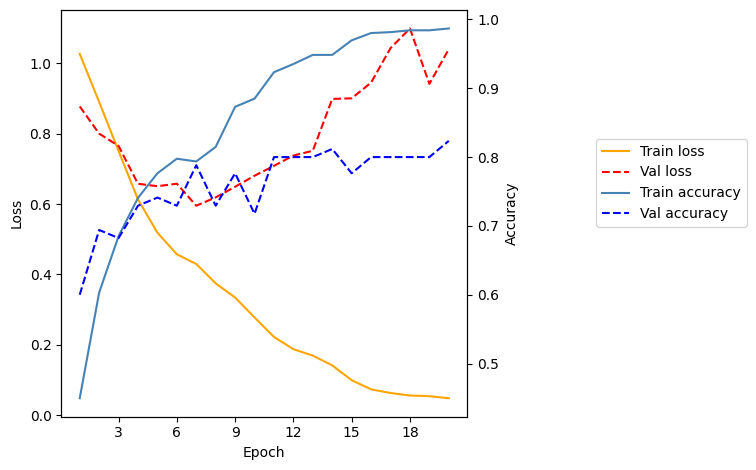

In [34]:
plot_training(model.history)

It can be seen, that the LSTM easily learns the task as the train loss steadily decreases and the accuracy increases.

Evaluate on test set

In [35]:
y_pred = model.predict(test_loader)

acc, f1, auc, mcc = eval_metrics(y_test, y_pred)
print(f"Acc: {acc}, F1: {f1}, AUC: {auc}, MCC: {mcc}")

Acc: 0.7867298578199052, F1: 0.7982278777492309, AUC: 0.853581911817364, MCC: 0.6751882153673884


## Training quantum case: QLSTM

Define hyperparameters and start training for QLSTM

Note: Training might take a **long** time. (around 100 minutes on default.qubit simulator for low complexity data set)

In [36]:
embedding_dim = 10
hidden_dim = 16
output_size = len(np.unique(y))
n_epochs = 20
n_qubits = 4
n_qlayers = 1
learning_rate = 1e-2
linear_dropout = 0 # dropout for linear layers
rnn_dropout = 0 # dropout for classical rnn layers
rnn_layers = 1 # number of classical rnn layers
weight_decay = 1e-4 # weight decay for optimizer / l2 regularization
momentum = 0 # momentum for optimizer
rnn = "qlstm" # rnn layer -> lstm/qlstm/gru
rnn_bidirectional = False # bidirectionality for classical rnn layer

model = LSTMClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    output_size=output_size,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    linear_dropout=linear_dropout,
    rnn_dropout=rnn_dropout,
    rnn_layers=rnn_layers,
    batch_size=batch_size,
    weight_decay=weight_decay,
    momentum=momentum,
    rnn=rnn,
    rnn_bidirectional=rnn_bidirectional,
    n_qubits=n_qubits,
    n_qlayers=n_qlayers,
    torch_device=device,
)
model.to(device)

# start training and track time
start_time = time.time()

model.fit(train_loader, val_loader)

training_time = round(time.time() - start_time, 2)
print(f"Training time: {training_time}sec")

Model will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)
Epoch 1 / 20: train/Loss = 1.065 val/Loss = 1.010 train/Acc = 0.43 val/Acc = 0.48
Epoch 2 / 20: train/Loss = 1.035 val/Loss = 1.019 train/Acc = 0.48 val/Acc = 0.48
Epoch 3 / 20: train/Loss = 1.032 val/Loss = 0.975 train/Acc = 0.48 val/Acc = 0.48
Epoch 4 / 20: train/Loss = 0.927 val/Loss = 0.818 train/Acc = 0.61 val/Acc = 0.67
Epoch 5 / 20: train/Loss = 0.820 val/Loss = 0.790 train/Acc = 0.66 val/Acc = 0.71
Epoch 6 / 20: train/Loss = 0.714 val/Loss = 0.693 train/Acc = 0.72 val/Acc = 0.71
Epoch 7 / 20: train/Loss = 0.678 val/Loss = 0.748 train/Acc = 0.73 val/Acc = 0.71
Epoch 8 / 20: train/Loss = 0.596 val/Loss = 0.761 train/Acc = 0.76 val/Acc = 0.72


Plot training curve

In [ ]:
plot_training(model.history)

Evaluate on test set

In [ ]:
y_pred = model.predict(test_loader)

acc, f1, auc, mcc = eval_metrics(y_test, y_pred)
print(f"Acc: {acc}, F1: {f1}, AUC: {auc}, MCC: {mcc}")